In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload signatures.rar manually

Saving signatures.rar to signatures.rar


In [ ]:
!sudo apt-get install unrar  # Install unrar for extraction
!pip install patoolib pyunpack

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
ERROR: Could not find a version that satisfies the requirement patoolib (from versions: none)
ERROR: No matching distribution found for patoolib


In [ ]:
!pip install pyunpack patool
!sudo apt-get install unrar  # Needed for RAR support

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.3/86.3 kB 2.1 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
from pyunpack import Archive
import os

# Create directory
os.makedirs('signatures', exist_ok=True)

# Extract (Colab stores uploaded files in '/content')
Archive('/content/signatures.rar').extractall('/content/signatures')

In [ ]:
!ls /content/signatures  # Should show 'original' and 'forged' folders

signatures


In [ ]:
import shutil
import glob

# Create new folders
os.makedirs('/content/signatures/genuine', exist_ok=True)
os.makedirs('/content/signatures/forged', exist_ok=True)

# Move genuine signatures (adjust pattern if needed)
for file in glob.glob('/content/signatures/original_*/*.png'):
    shutil.move(file, '/content/signatures/genuine')

# Move forged signatures
for file in glob.glob('/content/signatures/forged_*/*.png'):
    shutil.move(file, '/content/signatures/forged')

In [ ]:
import os
import shutil
from google.colab import drive

# Remove empty folders
!rm -r /content/signatures/forged
!rm -r /content/signatures/genuine

# Create proper directory structure
os.makedirs('/content/signatures/genuine', exist_ok=True)
os.makedirs('/content/signatures/forged', exist_ok=True)

# Move all genuine signatures (from full_org)
for file in os.listdir('/content/signatures/signatures/full_org'):
    if file.endswith('.png'):
        src = os.path.join('/content/signatures/signatures/full_org', file)
        dst = os.path.join('/content/signatures/genuine', file)
        shutil.move(src, dst)

# Move all forged signatures (from full_forg)
for file in os.listdir('/content/signatures/signatures/full_forg'):
    if file.endswith('.png'):
        src = os.path.join('/content/signatures/signatures/full_forg', file)
        dst = os.path.join('/content/signatures/forged', file)
        shutil.move(src, dst)

# Remove thumb.db files if they exist
!find /content/signatures -name "Thumbs.db" -type f -delete
!find /content/signatures -name "thumb.db" -type f -delete

# Remove now-empty folders
!rm -r /content/signatures/signatures/full_org
!rm -r /content/signatures/signatures/full_forg

In [ ]:
!rm -r /content/signatures/signatures

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix

# Verify GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: []


In [ ]:
# Configure image data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    validation_split=0.2,  # 80% train, 20% validation
    fill_mode='nearest'
)

# Load and augment data
train_generator = train_datagen.flow_from_directory(
    '/content/signatures',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '/content/signatures',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    subset='validation'
)

# Verify class indices
print("Class indices:", train_generator.class_indices)

Found 2112 images belonging to 2 classes.
Found 528 images belonging to 2 classes.
Class indices: {'forged': 0, 'genuine': 1}


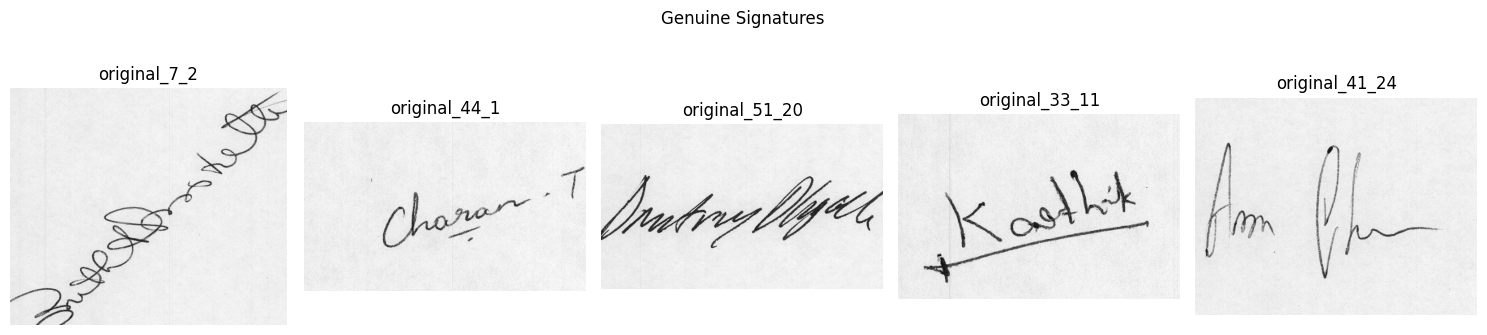

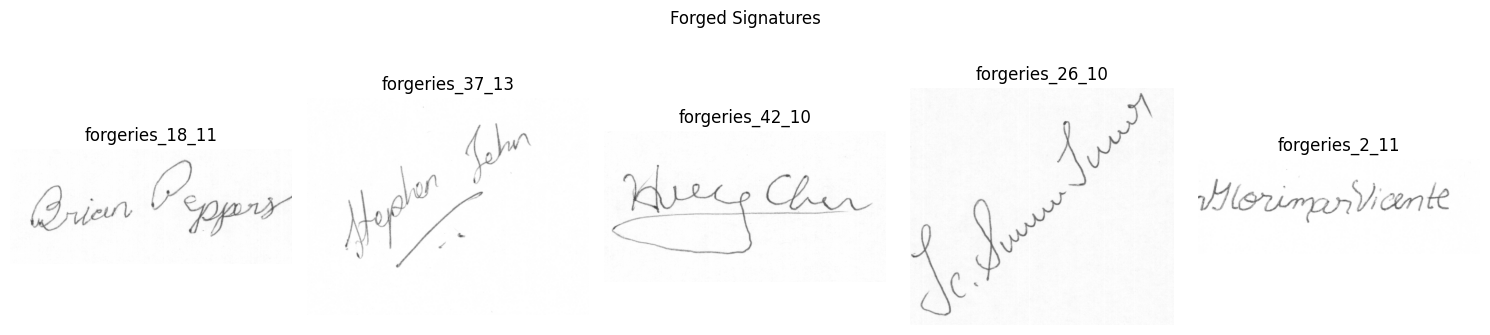

In [ ]:
import matplotlib.pyplot as plt
import os
import random

# Set paths
genuine_path = '/content/signatures/genuine'
forged_path = '/content/signatures/forged'

# Get random samples
def display_samples(class_path, title, num_samples=5):
    plt.figure(figsize=(15, 3))
    plt.suptitle(title, y=1.1)

    samples = random.sample(os.listdir(class_path), num_samples)

    for i, img_name in enumerate(samples):
        img_path = os.path.join(class_path, img_name)
        img = plt.imread(img_path)

        plt.subplot(1, num_samples, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(img_name.split('.')[0])

    plt.tight_layout()
    plt.show()

# Display genuine signatures
display_samples(genuine_path, "Genuine Signatures")

# Display forged signatures
display_samples(forged_path, "Forged Signatures")

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,811,393 (25.98 MB)

 Trainable params: 6,811,393 (25.98 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.5175 - loss: 0.7007 - precision: 0.5298 - recall: 0.5152 - val_accuracy: 0.5000 - val_loss: 0.6928 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.5142 - loss: 0.6895 - precision: 0.5054 - recall: 0.8922 - val_accuracy: 0.5947 - val_loss: 0.6664 - val_precision: 0.5740 - val_recall: 0.7348 - learning_rate: 0.0010
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.6352 - loss: 0.6463 - precision: 0.6449 - recall: 0.6264 - val_accuracy: 0.5777 - val_loss: 0.6672 - val_precision: 0.5509 - val_recall: 0.8409 - learning_rate: 0.0010
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.6101 - loss: 0.6521 - precision: 0.6102 - recall: 0.5835 - val_accuracy: 0.6534 - val_loss: 0.6057 - val_precision: 0.6506 - val_recall: 0.6629 - learning_rate: 0.0010
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.683

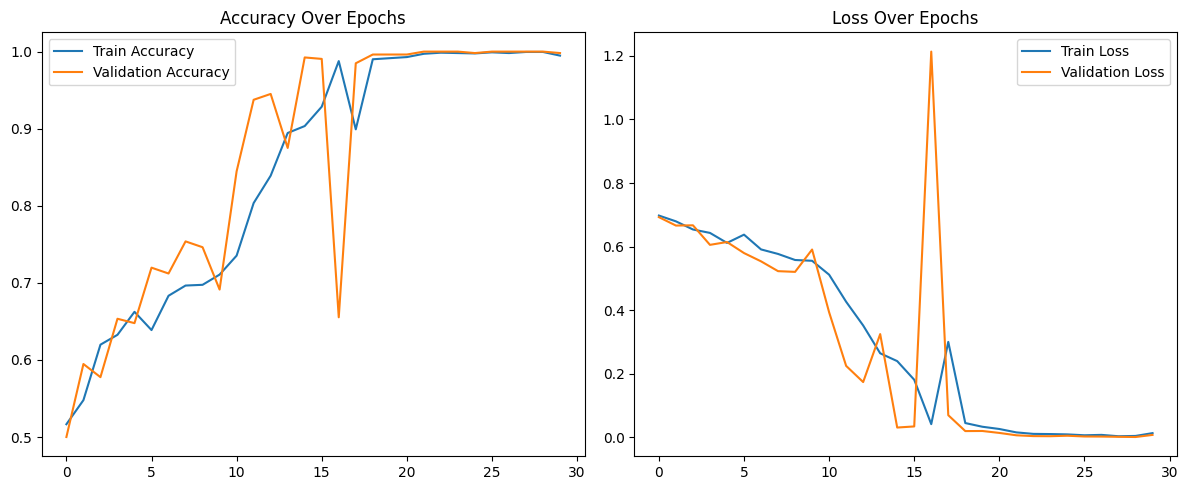

17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 542ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.47      0.47       264
           1       0.47      0.47      0.47       264

    accuracy                           0.47       528
   macro avg       0.47      0.47      0.47       528
weighted avg       0.47      0.47      0.47       528

Confusion Matrix:
[[125 139]
 [139 125]]


In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Generate predictions
val_preds = model.predict(val_generator)
val_preds = (val_preds > 0.5).astype(int)

# Classification report
print("\nClassification Report:")
print(classification_report(val_generator.classes, val_preds))

# Confusion matrix
conf_mat = confusion_matrix(val_generator.classes, val_preds)
print("Confusion Matrix:")
print(conf_mat)


Validation Set Evaluation:
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 534ms/step
Accuracy: 47.35%
Precision: 47.35%
Recall: 47.35%
F1 Score: 47.35%


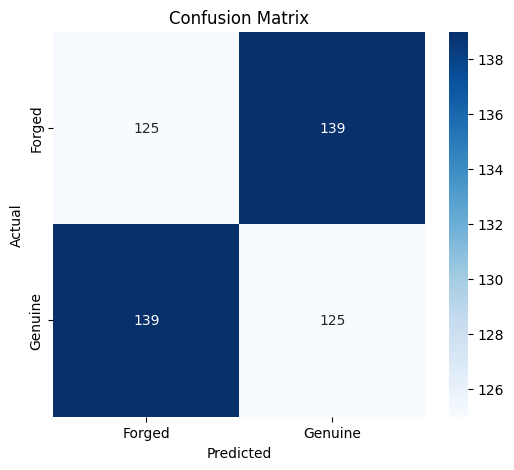


Training Set Evaluation:
66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 522ms/step
Accuracy: 51.33%
Precision: 51.33%
Recall: 51.33%
F1 Score: 51.33%


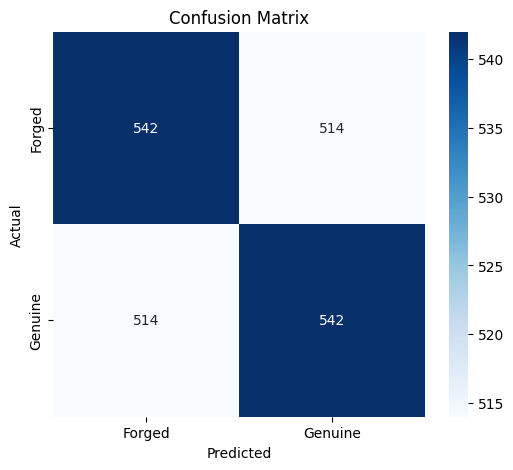

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

def evaluate_model(model, generator):
    # Get true labels and predictions
    y_true = generator.classes
    y_pred = model.predict(generator)
    y_pred = (y_pred > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Print metrics
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Precision: {precision:.2%}")
    print(f"Recall: {recall:.2%}")
    print(f"F1 Score: {f1:.2%}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Forged', 'Genuine'],
                yticklabels=['Forged', 'Genuine'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, precision, recall, f1

# Usage (after model training)
print("\nValidation Set Evaluation:")
val_accuracy, val_precision, val_recall, val_f1 = evaluate_model(model, val_generator)

print("\nTraining Set Evaluation:")
train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(model, train_generator)

In [ ]:
# Save the model
model.save('signature_forgery_detector.h5')

# Test on a new image
def predict_signature(image_path):
    img = tf.keras.preprocessing.image.load_img(
        image_path,
        target_size=(150, 150),
        color_mode='grayscale'
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    confidence = float(prediction[0][0])

    if confidence > 0.5:
        return f"Genuine (Confidence: {confidence:.2%})"
    else:
        return f"Forged (Confidence: {(1-confidence):.2%})"

# Example usage
test_image_path = "/content/signatures/genuine/original_1_1.png"  # Replace with your test image
print(predict_signature(test_image_path))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Genuine (Confidence: 99.95%)
